# AirPump failures

A customer is manufacturing devices containing air pumps that provide pressure for a machine cycle. Ideally, the air pressure rises sharply and remains stable throughout the machine's cycle, where it drops sharply. However, it can happen that the air pressure drops due to pump failure, or the air pressure rises or drops slowly.

The goal of the project is to detect a pump failure.
The typical air pump failure is a temporary pressure decrease in the first half of the cycle.


## Data structure


### Data

The data consists of the following columns (in this particular order):

- MachineId - Id of the machine
- MeasurementId - Id of the measured cycle
- Pressure - Air pressure (kPa)

The data does not contain timestamps, but for each machine and measured cycle combination, observations (i.e. rows) of the pressure values are ordered by time, and the time intervals between individual observations are always the same.


In [1]:
import pandas as pd

data = pd.read_parquet('data/data.parquet')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MachineId      object 
 1   MeasurementId  int64  
 2   Pressure       float64
dtypes: float64(1), int64(1), object(1)
memory usage: 422.7+ MB


,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


### Labels

The labels consists of the following columns (in this particular order):

- MachineId - Id of the machine
- MeasurementId - Id of the measured cycle
- PumpFailed - True if pump failed
- SlowStart - True if the preasure rised slowly
- SlowEnd - True if the presure dropped slowly


In [2]:
labels = pd.read_csv('data/labels.csv')
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  object
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN



## Task:

- Develop a predictive model for the PumpFailed column and report its performance in appropriate metrics.
- Explain your model.

---------------

As `data` is fairly large dataframe, I'm gonna change dtypes to the smallest possible dtypes to save memory. (3 times smaller)

In [3]:
data.describe()
data = data.astype({'MachineId':'category' ,'MeasurementId':'int16', 'Pressure':'float32'})
labels = labels.astype({'MachineId':'category' ,'MeasurementId':'int16'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18466364 entries, 0 to 18466363
Data columns (total 3 columns):
 #   Column         Dtype   
---  ------         -----   
 0   MachineId      category
 1   MeasurementId  int16   
 2   Pressure       float32 
dtypes: category(1), float32(1), int16(1)
memory usage: 140.9 MB


## Data exploration and undestanding

To better understand the data I will plot some measurement cycles with a different combinations of labels to see what it really looks like in data.

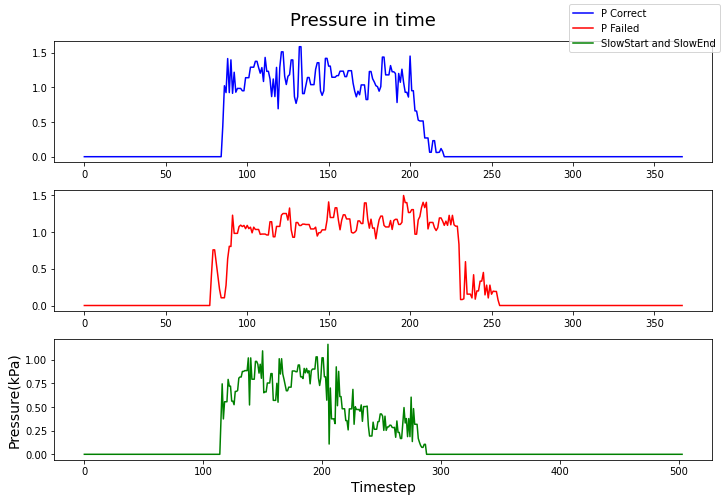

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

wrk_pmp = labels[(
    (labels['PumpFailed'] == False) &
    (labels['SlowStart'] == False) &
    (labels['SlowEnd'] == False)
)].iloc[0]

f_pmp = labels[(
    (labels['PumpFailed'] == True) &
    (labels['SlowStart'] == False) &
    (labels['SlowEnd'] == False)
)].iloc[0]

ssse_pmp = labels[(
    (labels['SlowStart'] == True) &
    (labels['SlowEnd'] == True)
)].iloc[0]

dgb = data.groupby(by=['MachineId', 'MeasurementId'])
wrk_pmp_press = data.loc[dgb.groups[tuple(wrk_pmp[['MachineId','MeasurementId']])],]['Pressure'].values # Pump worked correctly
f_pmp_press = data.loc[dgb.groups[tuple(f_pmp[['MachineId','MeasurementId']])],]['Pressure'].values    # Pump failed
ssse_pmp_press = data.loc[dgb.groups[tuple(ssse_pmp[['MachineId','MeasurementId']])],]['Pressure'].values # SlowStart SlowEnd

# plot
fig, axs = plt.subplots(3,1)
fig.set_size_inches(10, 7)
axs[0].plot(wrk_pmp_press, 'b', label='P Correct')
axs[1].plot(f_pmp_press, 'r', label='P Failed')
axs[2].plot(ssse_pmp_press, 'g', label='SlowStart and SlowEnd')
fig.legend()
fig.suptitle('Pressure in time', size=18)
plt.xlabel('Timestep', size=14)
plt.ylabel('Pressure(kPa)', size=14)
fig.tight_layout()

I am expecting the probability of the pumps failing to be much lower than 50%, therefore raw dataset would be imbalanced in terms of target variable `PumpFailed`.

It turns out the dataset is imbalanced in ratio 9:1. This imbalance will be dealt with later after feature engineering.

In [5]:
labels['PumpFailed'].value_counts()

False    23958
True      2942
Name: PumpFailed, dtype: int64

## Initial data preprocessing and Baseline model

With basic understanding of data I will move on to preprocessing of the labels and creating basic model that will serve as a performance baseline for future models.

For the baseline I will focus just on the labels that are already provided and won't do any feature engineering for now.

-------------

Dealing with missing values

<AxesSubplot:>

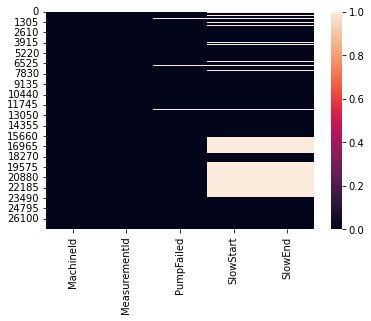

In [6]:
import seaborn as sns
sns.heatmap(labels.isna())

As we can see there are some missing labels even for target variable `PumpFailed`.

In [7]:
labels[(labels['PumpFailed'].isna())].head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
1,0_0_1,-1,NaN,NaN,NaN
4,0_1_0,-1,NaN,NaN,NaN
6,0_1_2,-1,NaN,NaN,NaN
7,0_1_3,-1,NaN,NaN,NaN
9,1_0_1,-1,NaN,NaN,NaN


It seems that `MeasurementId == -1` are continuous measurements of pressure over certain period of time and even over multiple measurement cycles.

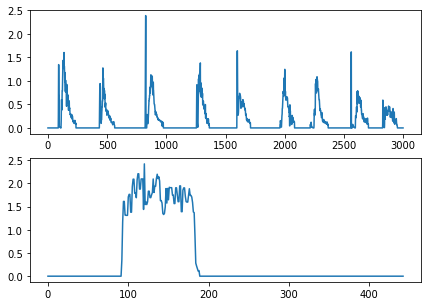

In [8]:
lgb = labels.groupby(by=['MachineId']).groups
fig, axs = plt.subplots(2,1)
fig.set_size_inches(7,5)
axs[0].plot(data.loc[dgb.groups[('0_1_0',-1)]]['Pressure'].reset_index(drop=True).iloc[0:3000])
axs[1].plot(data.loc[dgb.groups[('0_1_0',116)]]['Pressure'].reset_index(drop=True))

These measurement cycles would need to be extracted and labeled separately and therefore I will drop them for now.

<AxesSubplot:>

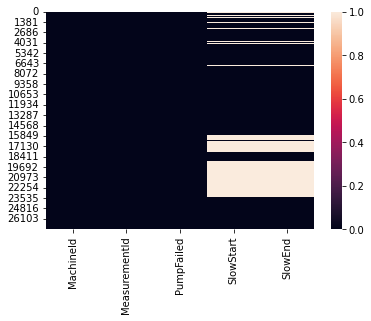

In [9]:
prep_labels = labels[~((labels['PumpFailed'].isna()) & (labels['MeasurementId'] == -1))]
sns.heatmap(prep_labels.isna())

Remaining rows with missing values always lack `SlowStart` and `SlowEnd` values at the same time. Instead of imputing the values (From for example past measurement cycles.) I'm gonna take `NaN` as third value to the `True` and `False` values as a sort of undefined start and end. OnehotEncoding will be used on these 3 valued features and to avoid collinearity created by one hot encoding I will simply drop the features created from `NaN` values.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

ct = ColumnTransformer([
    ('ohe',OneHotEncoder(handle_unknown='ignore'),['SlowStart', 'SlowEnd']),
    ('oe',OrdinalEncoder(), ['PumpFailed'])
    ],
)

transformed_labels = pd.DataFrame(ct.fit_transform(prep_labels), index=prep_labels.index, columns=ct.get_feature_names_out()).drop(columns=['ohe__SlowStart_nan','ohe__SlowEnd_nan'], errors='ignore')
transformed_labels.head()

,ohe__SlowStart_False,ohe__SlowStart_True,ohe__SlowEnd_False,ohe__SlowEnd_True,oe__PumpFailed
0,1.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0
5,1.0,0.0,1.0,0.0,1.0
8,0.0,1.0,1.0,0.0,0.0


## Models and metrics

The task to predict whether pump failed or not will be modeled as binary classification problem. For this purpose I will use `LogisticRegression` as a basic classifier, `RandomForestClassifier` since it allows to get feature importances with `feature_importances_` attribute, `KNeighborsClassifier` as nearest neighbor methods with correct data preprocessing work well as solid base, optionally I will try to use `SVC` support vector machine but I think that after feature engineering it will take just too long to train as dataset approaches the limits of SVM in terms of datapoints.

As we saw the dataset is imbalanced in approx. 1:9 ratio for pump failing. Simple `accuracy` metric won't do. For this purpose I'm gonna use `f1-score` and since all of the models used can in some way predict probabilities or certainty of labels `f1-score` will be used in combination with ROC curve and its `auc-score`. Priority in hyperparameter optimization is given to `f1-score` because `roc` doesn't take well in consideration the minority label class and will be more informative after balancing.

Helper functions for training and models evaluation summary.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

def models_training(X, y, suppvm=False):
    scoring = ['f1','roc_auc']
    estimators = {}

    lr_paramgrid = {
        'C':[100, 10, 1.0, 0.1, 0.01]
    }
    lr = GridSearchCV(LogisticRegression(max_iter=1000),
                        lr_paramgrid,
                        scoring=scoring,
                        refit='f1')
    lr.fit(X, y)
    estimators['lr'] = lr

    rf_paramgrid = {
        'n_estimators':[50, 100, 250],
        'max_depth':[2,3,4,None]
    }
    rf = GridSearchCV(RandomForestClassifier(),
                        rf_paramgrid,
                        scoring=scoring,
                        refit='f1')
    rf.fit(X, y)
    estimators['rf'] = rf

    knn_paramgrid = {
        'n_neighbors':range(3,13,2),
        'weights':['uniform','distance']
    }
    knn = GridSearchCV(KNeighborsClassifier(),
                        knn_paramgrid,
                        scoring=scoring,
                        refit='f1')
    knn.fit(X, y)
    estimators['knn'] = knn

    if suppvm:
        svc_paramgrid = {
            'C':[100, 10, 1.0, 0.1],
            'kernel':['poly','rbf'],
        }
        svc = GridSearchCV(svm.SVC(probability=True),
                            svc_paramgrid,
                            scoring=scoring,
                            refit='f1')
        svc.fit(X, y)
        estimators['svc'] = svc

    return estimators

def models_performance_summary(estimators):
    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(15,6)

    f1_score = []
    roc_auc_score = []
    est_name = []
    for _, est in estimators.items():
        i = est.best_index_
        f1_score.append(est.cv_results_['mean_test_f1'][i])
        roc_auc_score.append(est.cv_results_['mean_test_roc_auc'][i])
        est_name.append(est.estimator.__class__.__name__)

    # F1 score
    axs[0].bar(est_name, f1_score)
    axs[0].set_title('F1-Score', fontsize=16)
    axs[0].set_xticks(est_name)
    axs[0].tick_params(axis='x', rotation=45)

    # ROC AUC score
    axs[1].bar(est_name, roc_auc_score)
    axs[1].set_title('ROC-AUC-Score', fontsize=16)
    axs[1].set_xticks(est_name)
    axs[1].tick_params(axis='x', rotation=45)

    # RF Feature importances
    feature_imp_list = list(zip(estimators['rf'].best_estimator_.feature_names_in_, estimators['rf'].best_estimator_.feature_importances_))
    feature_imp_list = sorted(feature_imp_list, key=lambda x:x[1])
    axs[2].barh(list(zip(*feature_imp_list))[0], list(zip(*feature_imp_list))[1])
    axs[2].set_title('RF feature importances', fontsize=16)

    fig.suptitle('Overall performance', fontsize=20)
    fig.tight_layout()

## Baseline performance just on provided labels

As to be expected the performance is very poor as `f1-score` is nearly zero and `auc` being slightly above 0.5 means that it's just slightly better than predicting randomly.

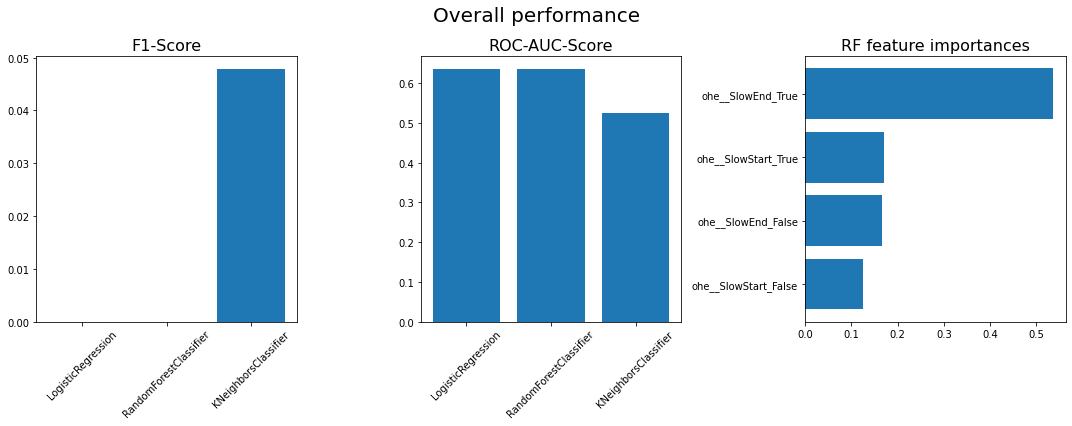

In [12]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
estimators = {}

X_train, X_test, y_train, y_test = train_test_split(
                                        transformed_labels.drop(columns='oe__PumpFailed'),
                                        transformed_labels['oe__PumpFailed'],
                                        test_size = 0.3,
                                        random_state = RANDOM_STATE)

estimators['baseline'] = models_training(X_train, y_train)
models_performance_summary(estimators['baseline'])

## Extracting new features from measurement cycles

Now for the feature engineering I'm gonna extract features from each measurement cycle. As measurement cycles contain lots of leading and trailing zeroes I'm gonna use just portion starting from first to last non-zero pressure value. Argument could be made to save leading zeroes as it could be counted in start speed but as I'm no expert on air pumps I will drop them. The features I will extract first are `CycleLength`, `MeanPressure`, `VarPressure`, `MaxPressure`, `LargestDrop`@5, `LargestDrop`@10 and `LargestDrop@20`. The features are all self-explanatory except maybe for `LargestDrop@N` as it's the largest percentage drop of pressure between 2 timesteps, where `N` is a number of timesteps from start and end of a cycle that won't be taken in consideration.

In [13]:
def extract_features(m_cycle):
    features = []
    cols = ['CycleLength', 'MeanPressure', 'VarPressure', 'MaxPressure', 'LargestDrop@5', 'LargestDrop@10', 'LargestDrop@20']

    nonzero = m_cycle['Pressure'].to_numpy().nonzero()[0]
    if len(nonzero) == 0:
        features = [0] * len(cols)
    else:
        first = nonzero[0]
        last = nonzero[-1]
        window = m_cycle.reset_index(drop=True).loc[first:last,'Pressure']
        features.append(last - first + 1)
        features.append(window.mean())
        features.append(window.var())
        features.append(window.max())
        features.append(window.iloc[5:-5,].pct_change().min())
        features.append(window.iloc[10:-10,].pct_change().min())
        features.append(window.iloc[20:-20,].pct_change().min())
    return pd.Series(features ,index=cols)

prep_data = data.merge(prep_labels[['MachineId', 'MeasurementId']], how='inner', on=['MachineId', 'MeasurementId'])
new_feat = prep_data.groupby(by=['MachineId', 'MeasurementId'], observed=True, sort=False).apply(extract_features).reset_index()
print(new_feat.isna().sum())

MachineId          0
MeasurementId      0
CycleLength        0
MeanPressure       0
VarPressure        1
MaxPressure        0
LargestDrop@5     15
LargestDrop@10    26
LargestDrop@20    54
dtype: int64


Some values are missing as nonzero windows in measurement cycles are probably just too narrow. As it's just few values I'm gonna fill them with `0`.

In [14]:
new_feat.loc[:, new_feat.dtypes.eq(float)] = new_feat.select_dtypes(float).fillna(0.0)

These features need to be scaled because of the models I'm using. As I'm using distance based model in kNN I will use just `MinMaxScaler`.

In [15]:
from sklearn.preprocessing import MinMaxScaler

new_data = prep_labels.merge(new_feat, how='inner', on=['MachineId','MeasurementId'])

ct = ColumnTransformer([
    ('ohe',OneHotEncoder(handle_unknown='ignore'),['SlowStart', 'SlowEnd']),
    ('oe',OrdinalEncoder(), ['PumpFailed']),
    ('sc', MinMaxScaler(), new_feat.select_dtypes(['float64']).columns.to_list())
    ],
)

transformed_labels = pd.DataFrame(ct.fit_transform(new_data), index=new_data.index, columns=ct.get_feature_names_out()).drop(columns=['ohe__SlowStart_nan','ohe__SlowEnd_nan'], errors='ignore')
transformed_labels.head()

,ohe__SlowStart_False,ohe__SlowStart_True,ohe__SlowEnd_False,ohe__SlowEnd_True,oe__PumpFailed,sc__CycleLength,sc__MeanPressure,sc__VarPressure,sc__MaxPressure,sc__LargestDrop@5,sc__LargestDrop@10,sc__LargestDrop@20
0,1.0,0.0,1.0,0.0,0.0,0.131021,0.334441,0.057477,0.274200,0.237410,0.511797,0.425450
1,1.0,0.0,1.0,0.0,0.0,0.191715,0.270514,0.016606,0.208550,0.396104,0.607846,0.493923
2,1.0,0.0,1.0,0.0,1.0,0.170520,0.312659,0.063411,0.259223,0.097136,0.094778,0.077015
3,1.0,0.0,1.0,0.0,1.0,0.147399,0.329822,0.034830,0.254409,0.532439,0.602769,0.489798
4,0.0,1.0,1.0,0.0,0.0,0.146435,0.316669,0.060482,0.253040,0.744253,0.805895,0.707431


## Performance after creating new features and scaling the data.

The performance compared to baseline is many times better. It seems that mean and variance are the most important features and all of the new features are few times better than just using the provided labels.

Here we can see that `ROC-AUC` doesn't do justice to minority class as `ROC-AUC` of `LogisticRegression` is nearly the same as of `RandomForestClassifier` but its `f1-score` is around 10x lower.

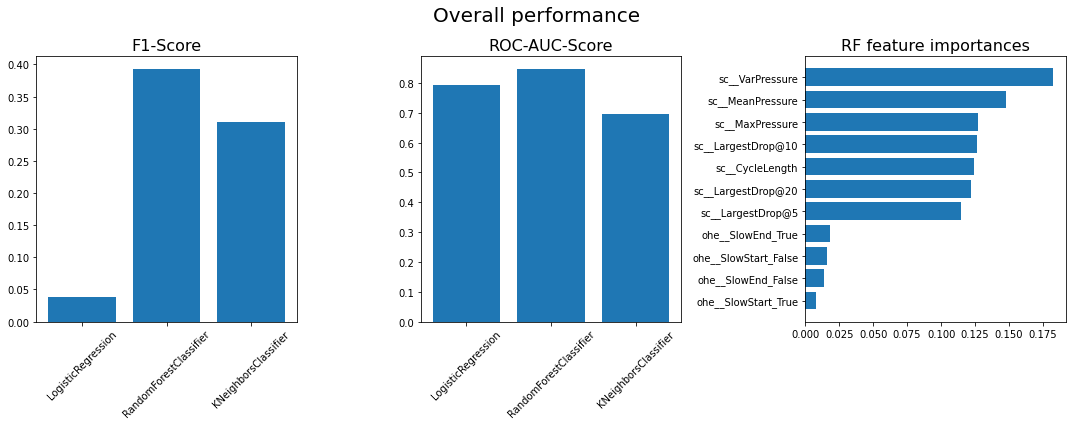

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
                                        transformed_labels.drop(columns='oe__PumpFailed'),
                                        transformed_labels['oe__PumpFailed'],
                                        test_size = 0.3,
                                        random_state = RANDOM_STATE)

estimators['feat_eng'] = models_training(X_train, y_train)
models_performance_summary(estimators['feat_eng'])

## Dealing with the imbalance

There are 3 ways to deal with imbalance in dataset.

Oversampling methods, creating new samples of minority class. Oversampling balances dataset at the cost of bigger computation time as the dataset will be larger.

Undersampling methods, removing some samples of majority class. Undersampling gives up some information of majority class in favor of minority.

Lastly combination of both.

As the time limit is nearly up I'm simply gonna use empirically best methods and won't do any further testing between other methods.

## Oversampling

With `SMOTE`, `RandomForestClassifier` reached well above of 0.9 in both `f1` and `roc-auc` scores, which could be considered as pretty good predictive model.

Mean and variance stay as the most important features.

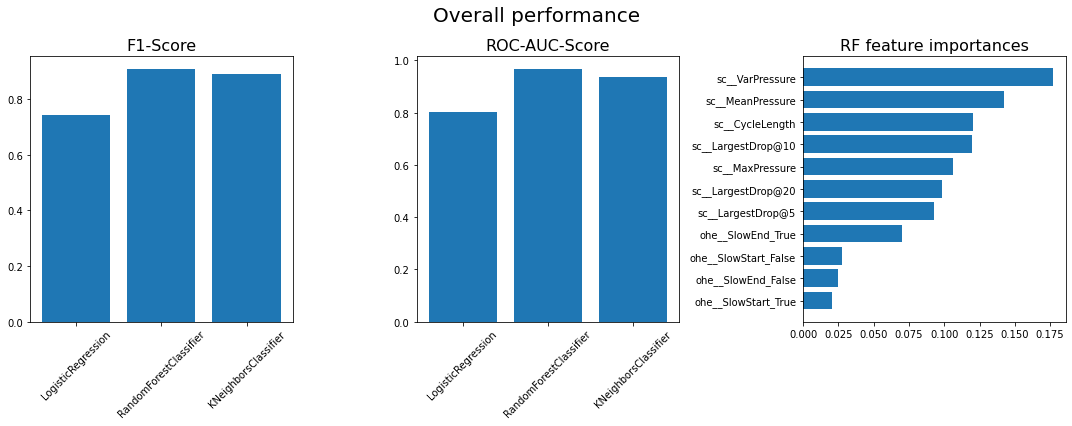

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek


sm = SMOTE(random_state=RANDOM_STATE)
X_ores, y_ores = sm.fit_resample(transformed_labels.drop(columns='oe__PumpFailed'),
                                transformed_labels['oe__PumpFailed'])

X_train, X_otest, y_train, y_otest = train_test_split(
                                        X_ores,
                                        y_ores,
                                        test_size = 0.3,
                                        random_state = RANDOM_STATE)

estimators['o_smpl'] = models_training(X_train, y_train)
models_performance_summary(estimators['o_smpl'])

## Undersampling

Undersampling using `TomekLinks` alone didn't bring much or any improvement at all. It seems that giving up the information of majority class won't be favorable in this particular problem.

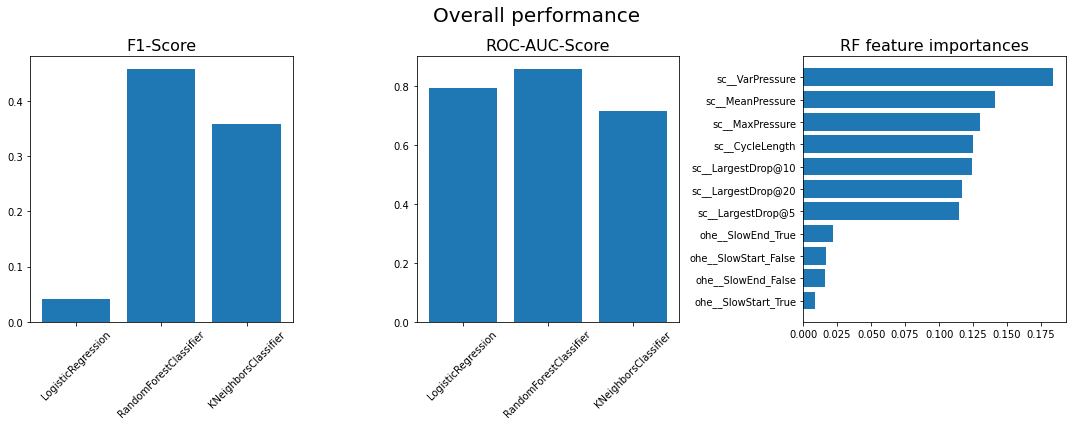

In [18]:
tl = TomekLinks()
X_ures, y_ures = tl.fit_resample(transformed_labels.drop(columns='oe__PumpFailed'),
                                transformed_labels['oe__PumpFailed'])

X_train, X_utest, y_train, y_utest = train_test_split(
                                        X_ures,
                                        y_ures,
                                        test_size = 0.3,
                                        random_state = RANDOM_STATE)

estimators['u_smpl'] = models_training(X_train, y_train)
models_performance_summary(estimators['u_smpl'])

## Combination - SMOTETomek

The performance is fairly similar to just oversampling. Further analysis of models is done to choose final model.

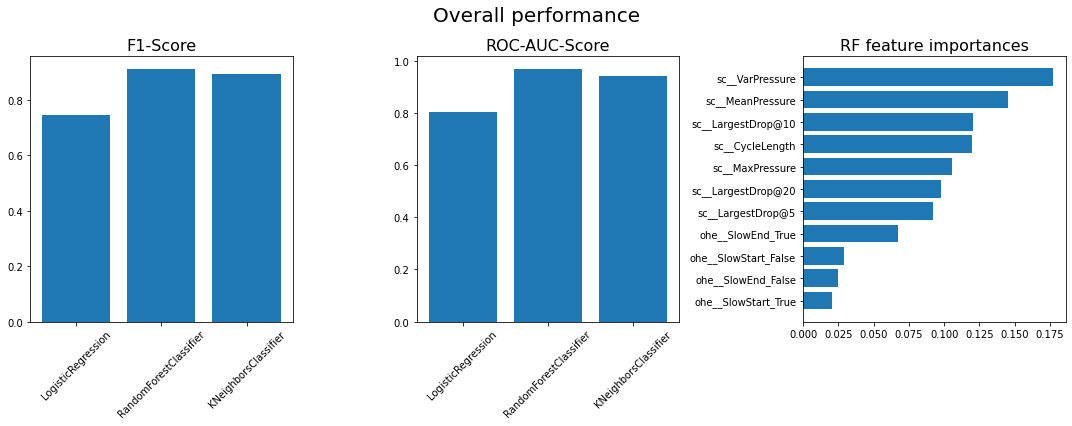

In [19]:
st = SMOTETomek()
X_cres, y_cres = st.fit_resample(transformed_labels.drop(columns='oe__PumpFailed'),
                                transformed_labels['oe__PumpFailed'],)

X_train, X_ctest, y_train, y_ctest = train_test_split(
                                        X_cres,
                                        y_cres,
                                        test_size = 0.3,
                                        random_state = RANDOM_STATE)

estimators['c_smpl'] = models_training(X_train, y_train)
models_performance_summary(estimators['c_smpl'])

 `RandomForestClassifier` trained on combination of sampling methods will be used as final as it gave slightly better performance on smaller dataset and the complexity of the models is same so Occam's razor approach can't be used.

In [22]:
print('Oversampling RF:', estimators['o_smpl']['rf'].best_score_, ', Combination RF:', estimators['c_smpl']['rf'].best_score_)
print('Oversampling RF HPs:', estimators['o_smpl']['rf'].best_params_, ', Combination RF HPs:', estimators['c_smpl']['rf'].best_params_)
print(f'Oversampling dataset shape {X_ores.shape}, Combination dataset shape {X_cres.shape}')

Oversampling RF: 0.9084915390190405 , Combination RF: 0.9130215881439139
Oversampling RF HPs: {'max_depth': None, 'n_estimators': 250} , Combination RF HPs: {'max_depth': None, 'n_estimators': 250}
Oversampling dataset shape (47916, 11), Combination dataset shape (47472, 11)


## Test data performance and Summary

Best binary classification model achieved score of `0.92 f1` and `0.97 auc` on testing data. Best classifier was `RandomForestClassifier` with `n_estimators = 250` and `max_depth = None` hyperparameters.

I'm fairly positive that better model could be achieved with more advanced feature engineering of measurement cycles e.g. extracting timeseries features. Deeper hyperparameter optimization would help slightly too and ensemble of trained models usually returns better performance as well.

I would say the notebook is quite easily expandable and could be worked on further.

Hyperparameters of best model: {'max_depth': None, 'n_estimators': 250}
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      7125
         1.0       0.90      0.94      0.92      7117

    accuracy                           0.92     14242
   macro avg       0.92      0.92      0.92     14242
weighted avg       0.92      0.92      0.92     14242



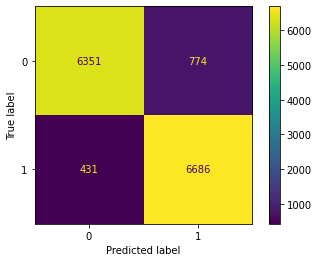

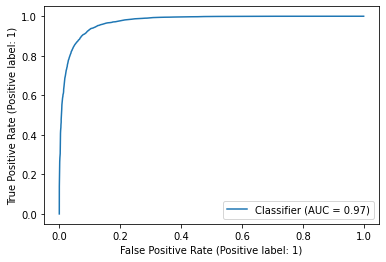

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, RocCurveDisplay

y_pred = estimators['c_smpl']['rf'].best_estimator_.predict(X_ctest)
y_scores = estimators['c_smpl']['rf'].best_estimator_.predict_proba(X_ctest)
cm = confusion_matrix(y_ctest, y_pred)
print(f'Hyperparameters of best model: {estimators["c_smpl"]["rf"].best_params_}')
print(classification_report(y_ctest, y_pred))

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
RocCurveDisplay.from_predictions(y_ctest, y_scores[:,1])